📦 Imports and Dependencies
This script sets up the environment for training a Convolutional Neural Network (CNN) using TensorFlow and tracks experiments using MLflow.

In [4]:
# 📦 General-purpose libraries
import os
import random
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
from PIL import Image

# 🤖 Machine Learning / Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential ,Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, MobileNetV2 ,VGG16,VGG19


# 📊 Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# 📈 MLflow Tracking
import mlflow


In [5]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Split into Train / Valid / Test DataFrames

In [6]:
import os
import pandas as pd

def create_dataframe(data_dir, target_folder):
    filepaths = []
    labels = []
    folder_path = os.path.join(data_dir, target_folder)

    if os.path.isdir(folder_path):
        for class_folder in os.listdir(folder_path):
            class_path = os.path.join(folder_path, class_folder)
            if os.path.isdir(class_path):
                for image_name in os.listdir(class_path):
                    image_path = os.path.join(class_path, image_name)
                    filepaths.append(image_path)
                    labels.append(class_folder)

    return pd.DataFrame({'filepath': filepaths, 'label': labels})


# 📂 Base directory
data_dir = r'/kaggle/input/teeth-classification/Teeth_Dataset'

# 📄 Create DataFrames
train_df = create_dataframe(data_dir, 'Training')
valid_df = create_dataframe(data_dir, 'Validation')
test_df  = create_dataframe(data_dir, 'Testing')
test_df

filepath label
0     /kaggle/input/teeth-classification/Teeth_Datas...    OC
1     /kaggle/input/teeth-classification/Teeth_Datas...    OC
2     /kaggle/input/teeth-classification/Teeth_Datas...    OC
3     /kaggle/input/teeth-classification/Teeth_Datas...    OC
4     /kaggle/input/teeth-classification/Teeth_Datas...    OC
...                                                 ...   ...
1023  /kaggle/input/teeth-classification/Teeth_Datas...   OLP
1024  /kaggle/input/teeth-classification/Teeth_Datas...   OLP
1025  /kaggle/input/teeth-classification/Teeth_Datas...   OLP
1026  /kaggle/input/teeth-classification/Teeth_Datas...   OLP
1027  /kaggle/input/teeth-classification/Teeth_Datas...   OLP

[1028 rows x 2 columns]

 Compare Class Folders in Train, Valid, and Test

In [7]:
# Get class names from each split
train_classes = set(os.listdir(os.path.join(data_dir, 'Training')))
valid_classes = set(os.listdir(os.path.join(data_dir, 'Validation')))
test_classes  = set(os.listdir(os.path.join(data_dir, 'Testing')))

# Print classes for review
print("Train Classes:", train_classes)
print("Validation Classes:", valid_classes)
print("Test Classes:", test_classes)

# Check if all sets are equal
if train_classes == valid_classes == test_classes:
    print("\n✅ All splits have the same classes.")
else:
    print("\n⚠️ Mismatch found between folders!")

    print("\nClasses in Training but not in Validation:", train_classes - valid_classes)
    print("Classes in Validation but not in Training:", valid_classes - train_classes)

    print("\nClasses in Training but not in Test:", train_classes - test_classes)
    print("Classes in Test but not in Training:", test_classes - train_classes)


Train Classes: {'MC', 'CaS', 'CoS', 'OLP', 'Gum', 'OT', 'OC'}
Validation Classes: {'MC', 'CaS', 'CoS', 'OLP', 'Gum', 'OT', 'OC'}
Test Classes: {'MC', 'CaS', 'CoS', 'OLP', 'Gum', 'OT', 'OC'}

✅ All splits have the same classes.


Bar Charts (Train, Validation, Test) in One Row

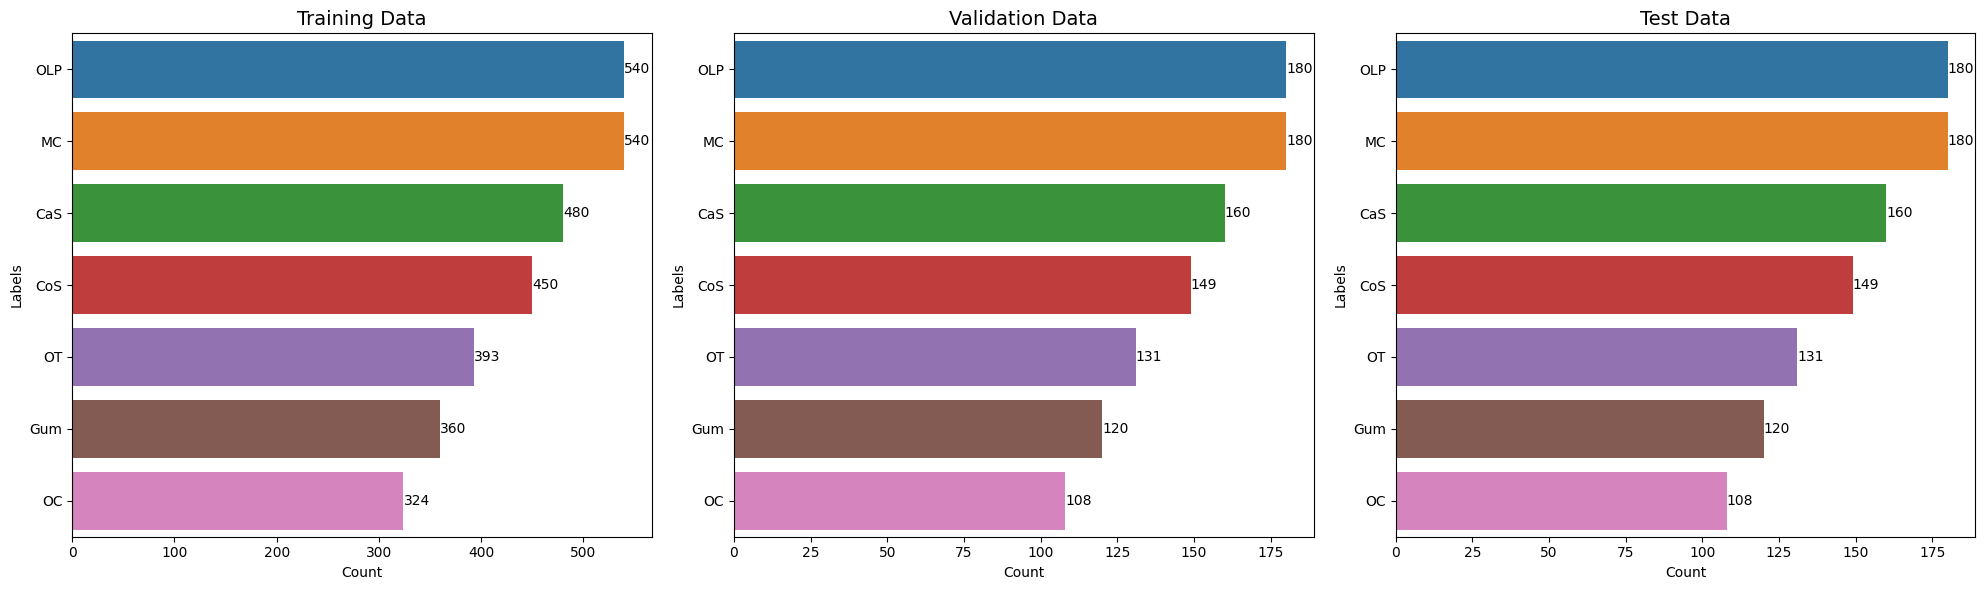

In [8]:
# Create a reusable function
def plot_label_distribution(df, title, ax):
    counts = df['label'].value_counts().reset_index()
    counts.columns = ['label', 'count']
    
    sns.barplot(data=counts, x='count', y='label', ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Count')
    ax.set_ylabel('Labels')

    # Annotate counts
    for index, row in counts.iterrows():
        ax.text(row['count'], index, str(row['count']), va='center', fontsize=10)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=False)

# Plot each distribution
plot_label_distribution(train_df, 'Training Data', axes[0])
plot_label_distribution(valid_df, 'Validation Data', axes[1])
plot_label_distribution(test_df, 'Test Data', axes[2])

plt.tight_layout()
plt.show()


Show Random Images from Different Classes

/tmp/ipykernel_35/760873458.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = train_df.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)


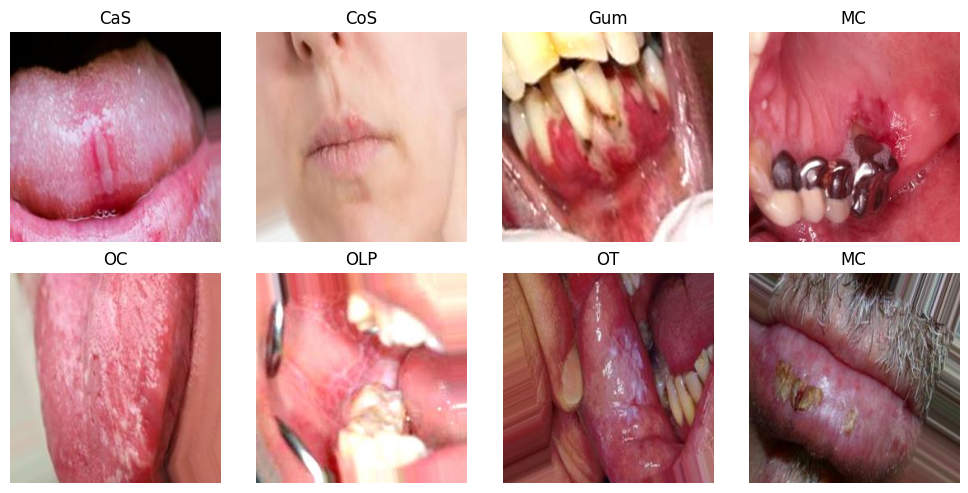

In [9]:
# 1 random image per class
samples = train_df.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)

# Ensure we have exactly 8 images (fill randomly if fewer)
if len(samples) < 8:
    remaining = 8 - len(samples)
    extra_samples = train_df.sample(remaining)
    samples = pd.concat([samples, extra_samples], ignore_index=True)

# Plot: 4 columns x 2 rows
plt.figure(figsize=(10, 5))
for i, row in enumerate(samples.itertuples()):
    plt.subplot(2, 4, i + 1)
    image = Image.open(row.filepath)
    plt.imshow(np.array(image) / 255.0)
    plt.title(row.label, color='black', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


 Preprocessing and Augmentation

In [10]:
# ✅ Set global seeds for full reproducibility

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Optional: ensure deterministic TF behavior (if TF 2.10+)
tf.config.experimental.enable_op_determinism()

batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# ✅ Shuffle DataFrames manually (once) for reproducible order
train_df = train_df.sample(frac=1, random_state=seed).reset_index(drop=True)
valid_df = valid_df.sample(frac=1, random_state=seed).reset_index(drop=True)
# Optional: test_df too, if needed
#test_df = test_df.sample(frac=1, random_state=seed).reset_index(drop=True)

# ✅ ImageDataGenerators
gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# ✅ Generators with shuffle=False
train_gen = gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,  # 🔒 fixed order
    batch_size=batch_size
)

valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,  # 🔒 fixed order
    batch_size=batch_size
)



Found 3087 validated image filenames belonging to 7 classes.
Found 1028 validated image filenames belonging to 7 classes.


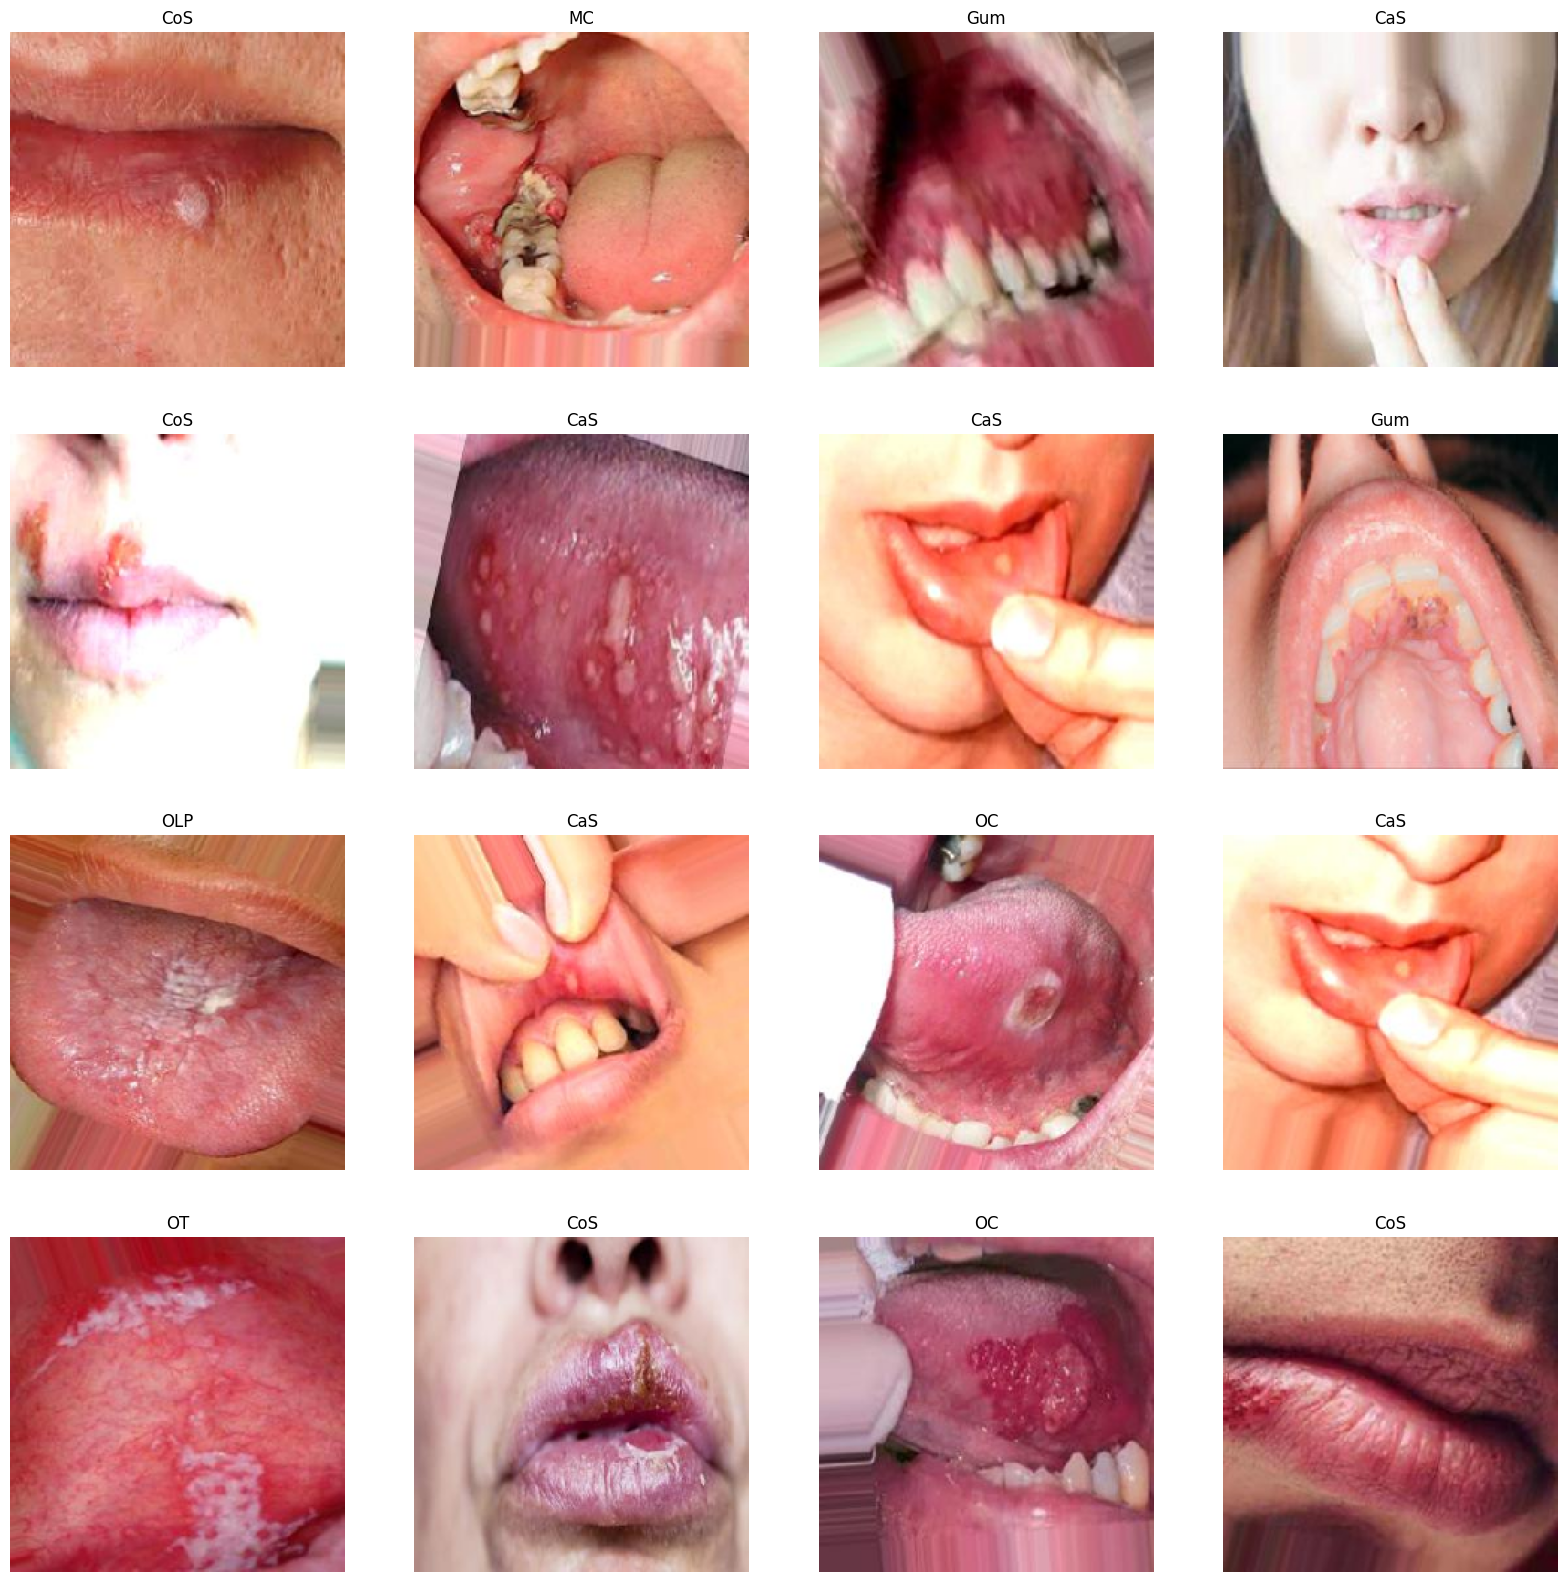

In [11]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

## 🧠 Model Architecture

The model is a custom **Convolutional Neural Network (CNN)** with:

- 4 convolution blocks (Conv2D + BatchNorm + MaxPool)
- GlobalAveragePooling2D
- Dense layer (128 units + Dropout)
- Output layer with softmax for 7 classes

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),  # Much fewer parameters than Flatten

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(7, activation='softmax')  # Final classification layer (7 classes)
])
optimizer = Adamax(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751750649.138013      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 424,135 (1.62 MB)

 Trainable params: 423,175 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

####  MLflow for experiment tracking, and also saving the best model during training using ModelCheckpoint

In [13]:
# ✅ Enable MLflow autologging
mlflow.tensorflow.autolog()
epochs = 50

# ✅ Model checkpoint path
checkpoint_path = "best_teeth_model_CNN_Custom.h5"

# ✅ Callbacks without EarlyStopping
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-4)
]


---

## 🧠 Model Training Overview

The model is trained using a custom Convolutional Neural Network (CNN) built with TensorFlow/Keras. It is capable of classifying oral diseases into 7 classes with a combination of Conv2D, BatchNormalization, Pooling, and Dense layers.

---

## 🔁 Training Workflow

- **Input image size**: 224 × 224 × 3
- **Loss function**: `categorical_crossentropy`
- **Optimizer**: `Adamax` (learning rate = 0.001)
- **Metrics**: `accuracy`, `precision`, `recall`
- **Augmentation**: `image_dataset_from_directory` with `validation_split`
- **Dataset format**: One folder per class (7 total)
- **Classes**: `CaS`, `CoS`, `Gum`, `MC`, `OC`, `OLP`, `OT`

---

## 🧪 MLflow Experiment Tracking

MLflow is used to automatically track and log model training progress, including:

- Model parameters and architecture
- Training/validation loss and accuracy per epoch
- Optimizer type and learning rate
- Total model parameters
- Model summary (as artifact)
- Best `.h5` model weights via `ModelCheckpoint`


In [14]:
# Start MLflow tracking
with mlflow.start_run(run_name="teeth_classifier_CNN_Custom_v2"):
    # Log hyperparameters
    mlflow.log_param("img_size", img_size)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)

        # Log optimizer dynamically
    optimizer_name = optimizer.__class__.__name__
    learning_rate = optimizer.learning_rate.numpy()
    mlflow.log_param("optimizer", f"{optimizer_name}({learning_rate})")

    # Log number of layers and total trainable parameters
    mlflow.log_param("num_layers", len(model.layers))
    mlflow.log_param("total_params", model.count_params())

    # Build and log architecture string (e.g., Conv2D → BN → MaxPool → Dense)
    layer_info = [layer.__class__.__name__ for layer in model.layers]
    architecture_str = " → ".join(layer_info)
    mlflow.log_param("architecture", architecture_str)

    # Save full model summary to a text file and log it
    summary_buffer = io.StringIO()
    with redirect_stdout(summary_buffer):
        model.summary()
    summary_text = summary_buffer.getvalue()

    with open("model_CNN_Custom.txt", "w") as f:
        f.write(summary_text)
    mlflow.log_artifact("model_CNN_Custom.txt")

    # Train the model and log training
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=valid_gen,
        callbacks=callbacks
    )


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 424,135 (1.62 MB)

 Trainable params: 423,175 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

2025/07/05 21:24:14 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
2025/07/05 21:24:14 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1751750660.427336     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.3296 - loss: 1.7945 - precision: 0.5294 - recall: 0.1208

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 325ms/step - accuracy: 0.3301 - loss: 1.7928 - precision: 0.5300 - recall: 0.1210 - val_accuracy: 0.2626 - val_loss: 1.7487 - val_precision: 0.6667 - val_recall: 0.0350 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.4713 - loss: 1.3702 - precision: 0.6842 - recall: 0.2030 - val_accuracy: 0.4339 - val_loss: 1.5018 - val_precision: 0.6771 - val_recall: 0.1469 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.5201 - loss: 1.2408 - precision: 0.6957 - recall: 0.2702 - val_accuracy: 0.4951 - val_loss: 1.3296 - val_precision: 0.7397 - val_recall: 0.2101 - learning_rate: 0.0010
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.5577 - loss: 1.1640 - precision: 0.7106 - recall: 0.3287 - val_accuracy: 0.6196 - val_loss: 1.0610 - val_precision: 0.8252 - val_recall: 0.3628 - learning_rate: 0.0010
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.6134

2025/07/05 21:37:26 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/07/05 21:37:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/05 21:37:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/07/05 21:37:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## 📊 Model Evaluation

After training, we visualize performance using:

- Accuracy
- Precision
- Recall
- Loss

Each metric is plotted for both training and validation data.


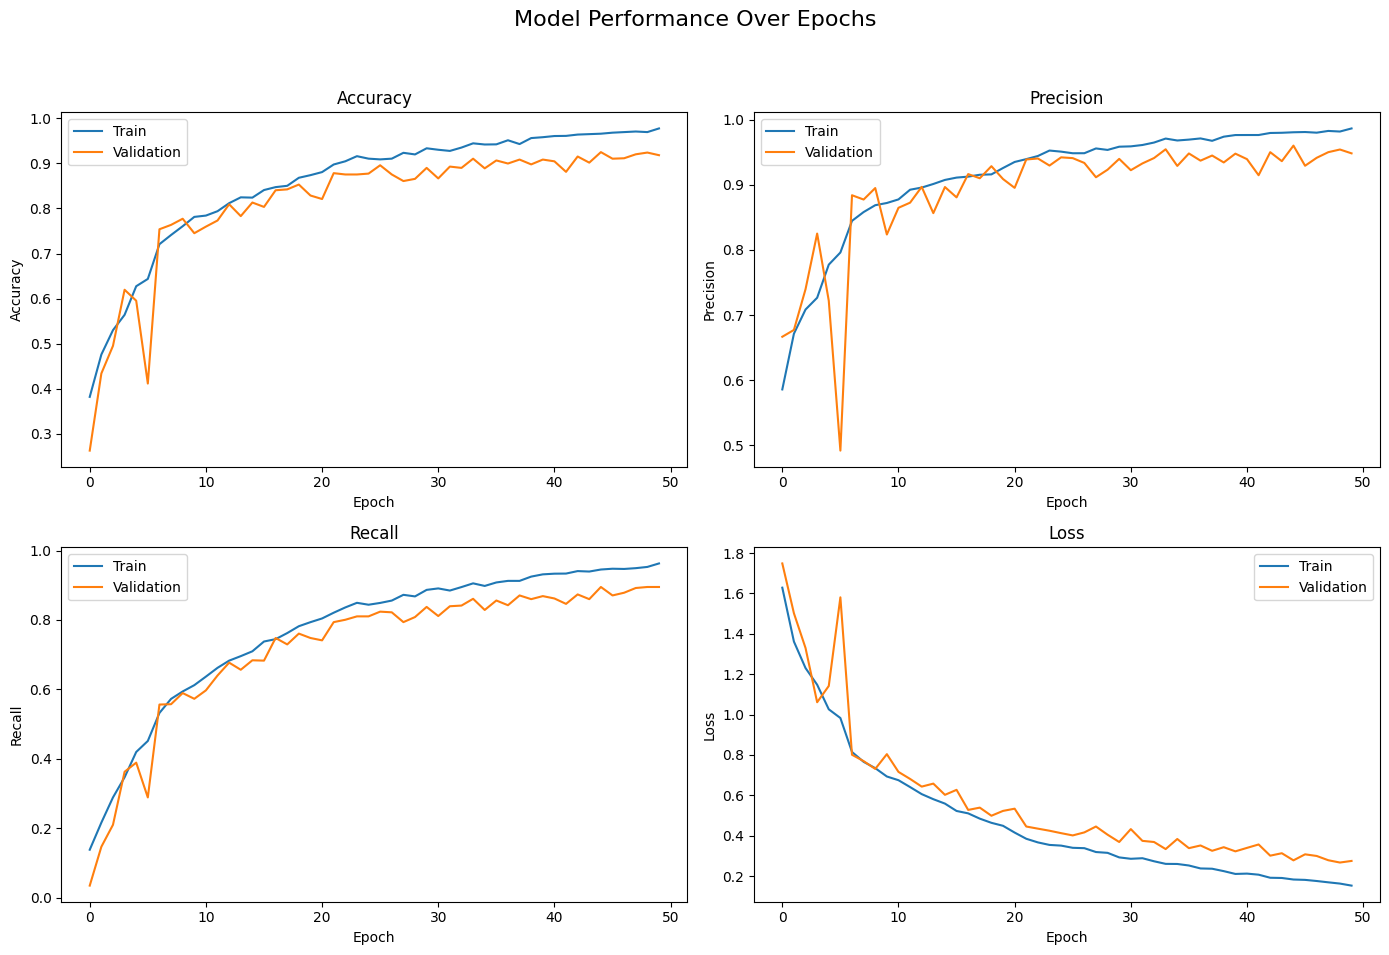

In [15]:
import matplotlib.pyplot as plt

# 📊 Step 6: Evaluate the Model with all key metrics
history_dict = history.history

# Set up subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Over Epochs', fontsize=16)

# Accuracy
axs[0, 0].plot(history_dict['accuracy'], label='Train')
axs[0, 0].plot(history_dict['val_accuracy'], label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Precision
axs[0, 1].plot(history_dict['precision'], label='Train')
axs[0, 1].plot(history_dict['val_precision'], label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].legend()

# Recall
axs[1, 0].plot(history_dict['recall'], label='Train')
axs[1, 0].plot(history_dict['val_recall'], label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()

# Loss
axs[1, 1].plot(history_dict['loss'], label='Train')
axs[1, 1].plot(history_dict['val_loss'], label='Validation')
axs[1, 1].set_title('Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Found 1028 files belonging to 7 classes.
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9193 - loss: 0.2630

✅ Test Accuracy: 89.79%
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

📊 Classification Report:
              precision    recall  f1-score   support

         CaS       0.91      0.94      0.93       160
         CoS       0.97      0.93      0.95       149
         Gum       0.95      0.92      0.93       120
          MC       0.87      0.87      0.87       180
          OC       0.97      0.77      0.86       108
         OLP       0.80      0.93      0.86       180
          OT       0.91      0.89      0.90       131

    accuracy                           0.90      1028
   macro avg       0.91      0.89      0.90      1028
weighted avg       0.90      0.90      0.90      1028



/tmp/ipykernel_35/1193141307.py:63: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


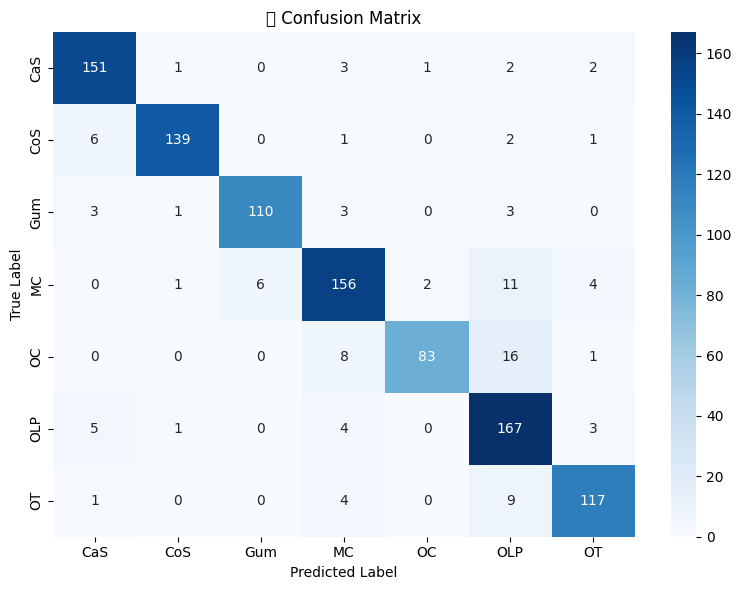

In [16]:
# -----------------------------
# 1. Config
# -----------------------------
class_names = ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]
test_dir = "/kaggle/input/teeth-classification/Teeth_Dataset/Testing"  # Path to your test folder
img_size = (224, 224)
batch_size = 32

# -----------------------------
# 2. Load model without compiling
# -----------------------------
model = tf.keras.models.load_model("/kaggle/working/best_teeth_model_CNN_Custom.h5", compile=False)

# Recompile it manually with standard metrics
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# -----------------------------
# 3. Load test dataset
# -----------------------------
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",  # One-hot encoded
    image_size=img_size,
    shuffle=False,
    batch_size=batch_size
)

# -----------------------------
# 4. Evaluate the model
# -----------------------------
loss, accuracy = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# -----------------------------
# 5. Make predictions
# -----------------------------
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([np.argmax(label.numpy(), axis=1) for _, label in test_ds])

# -----------------------------
# 6. Classification Report
# -----------------------------
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# -----------------------------
# 7. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧾 Confusion Matrix")
plt.tight_layout()
plt.show()


In [19]:
# === Reproducibility ===
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# === Parameters ===
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
num_classes = 7
epochs = 20

# === Shuffle DataFrames deterministically ===
train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
valid_df = valid_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# === Data Augmentation ===
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_aug = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

# === Generators ===
train_gen = train_aug.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

valid_gen = valid_aug.flow_from_dataframe(
    valid_df,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)




Found 3087 validated image filenames belonging to 7 classes.
Found 1028 validated image filenames belonging to 7 classes.


In [20]:
num_classes = 7
epochs = 20


# Build the MobileNetV2 model
# === Build Model ===
def build_mobilenet_model(input_shape=img_shape, num_classes=7):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # enable fine-tuning

    # Freeze all but last 30 layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Added dropout
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model


In [21]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# ✅ Model checkpoint path
checkpoint_path = "mobilenet_model.h5"

# ✅ Callbacks without EarlyStopping
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-4)
   # EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

# Start MLflow tracking
with mlflow.start_run(run_name="mobilenet_classifier_v1"):
    # Log hyperparameters
    mlflow.log_param("img_size", img_size)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)

    # Log optimizer dynamically
    optimizer_name = optimizer.__class__.__name__
    learning_rate = optimizer.learning_rate.numpy()
    mlflow.log_param("optimizer", f"{optimizer_name}({learning_rate})")

    # Build model
    model = build_mobilenet_model(input_shape=img_shape, num_classes=num_classes)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
            metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')])

    # Log number of layers and trainable params
    mlflow.log_param("num_layers", len(model.layers))
    mlflow.log_param("total_params", model.count_params())

    # Log short architecture string (first 10 layers only)
    short_arch = " → ".join(layer_info[:10]) + " → ..."
    mlflow.log_param("architecture", short_arch)

    # Save full architecture as artifact
    with open("model_summary_mobilenet.txt", "w") as f:
        f.write(architecture_str)
    mlflow.log_artifact("model_summary_mobilenet.txt")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
# Train the model and log training
history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=valid_gen,
        callbacks=callbacks
    )

2025/07/05 21:41:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a09433ed06cc46928a9271a413d9b205', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/07/05 21:41:49 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
2025/07/05 21:41:49 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 62s 453ms/step - accuracy: 0.5162 - loss: 1.3629 - precision: 0.6686 - recall: 0.3647 - val_accuracy: 0.2986 - val_loss: 9.8055 - val_precision: 0.3013 - val_recall: 0.2986 - learning_rate: 0.0010
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 428ms/step - accuracy: 0.8212 - loss: 0.5795 - precision: 0.8606 - recall: 0.7524 - val_accuracy: 0.3161 - val_loss: 11.3756 - val_precision: 0.3202 - val_recall: 0.3152 - learning_rate: 0.0010
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 430ms/step - accuracy: 0.8854 - loss: 0.3710 - precision: 0.9148 - recall: 0.8550 - val_accuracy: 0.1858 - val_loss: 17.2875 - val_precision: 0.1858 - val_recall: 0.1858 - learning_rate: 0.0010
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 445ms/step - accuracy: 0.9280 - loss: 0.2444 - precision: 0.9449 - recall: 0.9039 - val_accuracy: 0.3405 - val_loss: 12.6610 - val_precision: 0.3418 - val_recall: 0.3405 - learning_rate: 2.0000e-04
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 423ms/step 

2025/07/05 21:56:04 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/07/05 21:56:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/05 21:56:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/07/05 21:56:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


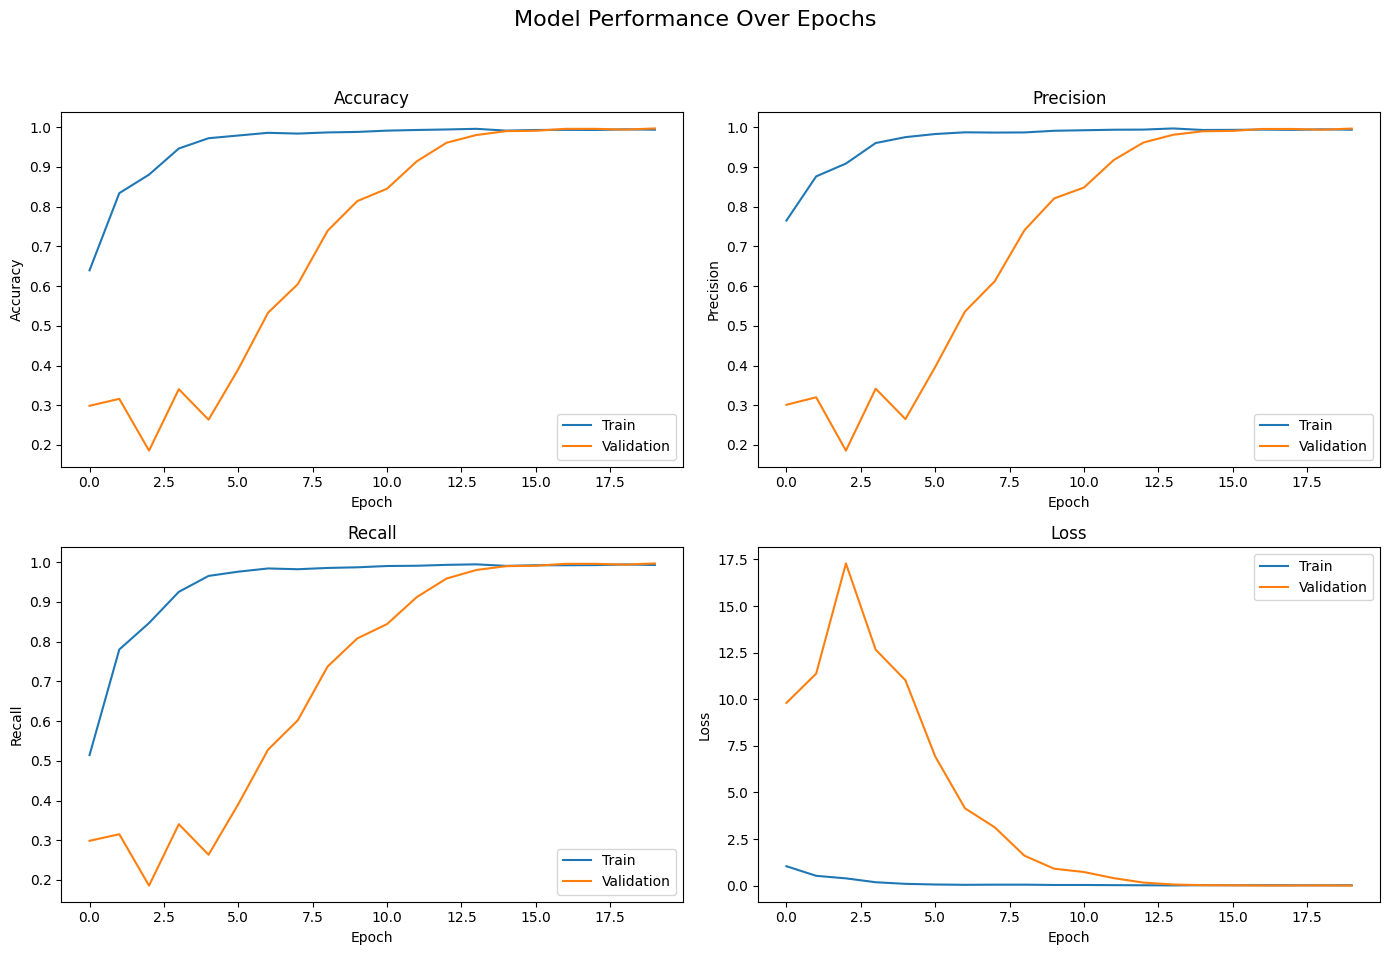

In [23]:
# 📊 Step 6: Evaluate the Model with all key metrics
history_dict = history.history

# Set up subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Over Epochs', fontsize=16)

# Accuracy
axs[0, 0].plot(history_dict['accuracy'], label='Train')
axs[0, 0].plot(history_dict['val_accuracy'], label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Precision
axs[0, 1].plot(history_dict['precision'], label='Train')
axs[0, 1].plot(history_dict['val_precision'], label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].legend()

# Recall
axs[1, 0].plot(history_dict['recall'], label='Train')
axs[1, 0].plot(history_dict['val_recall'], label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()

# Loss
axs[1, 1].plot(history_dict['loss'], label='Train')
axs[1, 1].plot(history_dict['val_loss'], label='Validation')
axs[1, 1].set_title('Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Found 1028 files belonging to 7 classes.
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9985 - loss: 0.0102

✅ Test Accuracy: 99.71%
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step

📊 Classification Report:
              precision    recall  f1-score   support

         CaS       1.00      1.00      1.00       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      1.00      1.00       120
          MC       1.00      0.99      0.99       180
          OC       0.98      1.00      0.99       108
         OLP       1.00      0.99      1.00       180
          OT       0.99      1.00      1.00       131

    accuracy                           1.00      1028
   macro avg       1.00      1.00      1.00      1028
weighted avg       1.00      1.00      1.00      1028



/tmp/ipykernel_35/2440310660.py:72: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


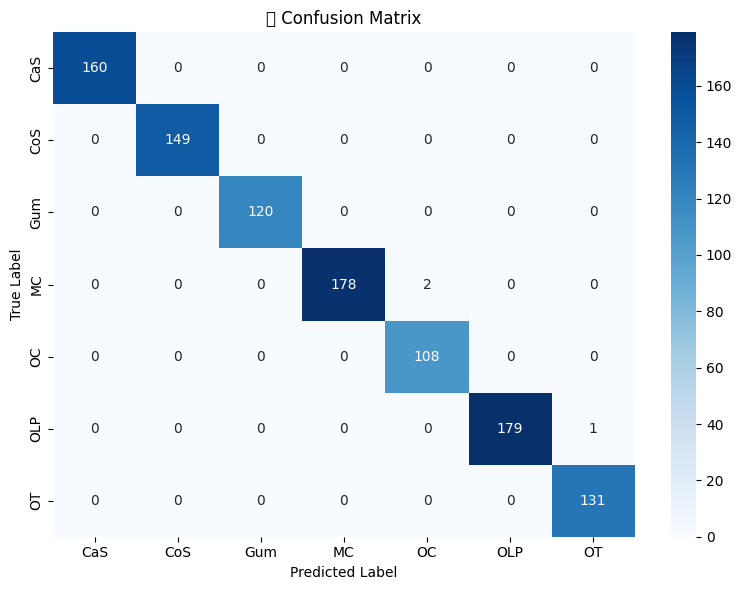

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1. Config
# -----------------------------
class_names = ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]
test_dir = "/kaggle/input/teeth-classification/Teeth_Dataset/Testing"
img_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# -----------------------------
# 2. Load model
# -----------------------------
model = tf.keras.models.load_model("/kaggle/working/mobilenet_model.h5", compile=False)
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# -----------------------------
# 3. Load & preprocess test data
# -----------------------------
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # ⚠️ normalize to match training
    return image, label

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=img_size,
    shuffle=False,
    batch_size=batch_size
).map(preprocess).prefetch(buffer_size=AUTOTUNE)

# -----------------------------
# 4. Evaluate the model
# -----------------------------
loss, accuracy = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# -----------------------------
# 5. Predictions
# -----------------------------
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([np.argmax(label.numpy(), axis=1) for _, label in test_ds])

# -----------------------------
# 6. Classification Report
# -----------------------------
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# -----------------------------
# 7. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧾 Confusion Matrix")
plt.tight_layout()
plt.show()


In [25]:
!zip -r mlruns.zip /kaggle/working


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/best_teeth_model_CNN_Custom.h5 (deflated 10%)
  adding: kaggle/working/mlruns/ (stored 0%)
  adding: kaggle/working/mlruns/0/ (stored 0%)
  adding: kaggle/working/mlruns/0/5bfd024e81a748fc93dcc036386b462e/ (stored 0%)
  adding: kaggle/working/mlruns/0/5bfd024e81a748fc93dcc036386b462e/metrics/ (stored 0%)
  adding: kaggle/working/mlruns/0/5bfd024e81a748fc93dcc036386b462e/meta.yaml (deflated 39%)
  adding: kaggle/working/mlruns/0/5bfd024e81a748fc93dcc036386b462e/artifacts/ (stored 0%)
  adding: kaggle/working/mlruns/0/5bfd024e81a748fc93dcc036386b462e/artifacts/model_summary_mobilenet.txt (deflated 70%)
  adding: kaggle/working/mlruns/0/5bfd024e81a748fc93dcc036386b462e/params/ (stored 0%)
  adding: kaggle/working/mlruns/0/5bfd024e81a748fc93dcc036386b462e/params/optimizer (deflated 11%)
  adding: kaggle/working/mlruns/0/5bfd024e81a748fc93dcc036386b462e/params/architecture (deflated 69%)
  adding: kaggle/working/mlruns/0/5bfd024